# One step multivariate model

Download zipfile from https://www.dropbox.com/s/pqenrr2mcvl0hk9/GEFCom2014.zip?dl=0 and store in the data folder.

In this notebook, we demonstrate how to:
- prepare time series data for training a RNN forecasting model
- get data in the required shape for the keras API
- implement a RNN model in keras to predict the next step ahead (time *t+1*) in the time series. This model uses recent values of temperature, as well as load, as the model input.
- enable early stopping to reduce the likelihood of model overfitting
- evaluate the model on a test dataset

The data in this example is taken from the GEFCom2014 forecasting competition<sup>1</sup>. It consists of 3 years of hourly electricity load and temperature values between 2012 and 2014. The task is to forecast future values of electricity load. In this example, we show how to forecast one time step ahead, using historical load and temperature data.

<sup>1</sup>Tao Hong, Pierre Pinson, Shu Fan, Hamidreza Zareipour, Alberto Troccoli and Rob J. Hyndman, "Probabilistic energy forecasting: Global Energy Forecasting Competition 2014 and beyond", International Journal of Forecasting, vol.32, no.3, pp 896-913, July-September, 2016.

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from collections import UserDict
%matplotlib inline

pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(precision=2)

In [2]:
%run -i common/load_data.py
%run -i common/mape.py
%run -i common/TimeSeriesTensor.py
%run -i common/create_evaluation_df.py

Load data into Pandas dataframe

In [3]:
if not os.path.exists(os.path.join('data', 'energy.csv')):
    %run common/extract_data.py
energy = load_data()
energy.head()

,load,temp
2012-01-01 00:00:00,"2,698.00",32.00
2012-01-01 01:00:00,"2,558.00",32.67
2012-01-01 02:00:00,"2,444.00",30.00
2012-01-01 03:00:00,"2,402.00",31.00
2012-01-01 04:00:00,"2,403.00",32.00


In [4]:
valid_start_dt = '2014-09-01 00:00:00'
test_start_dt = '2014-11-01 00:00:00'

Plot all load and temperature data

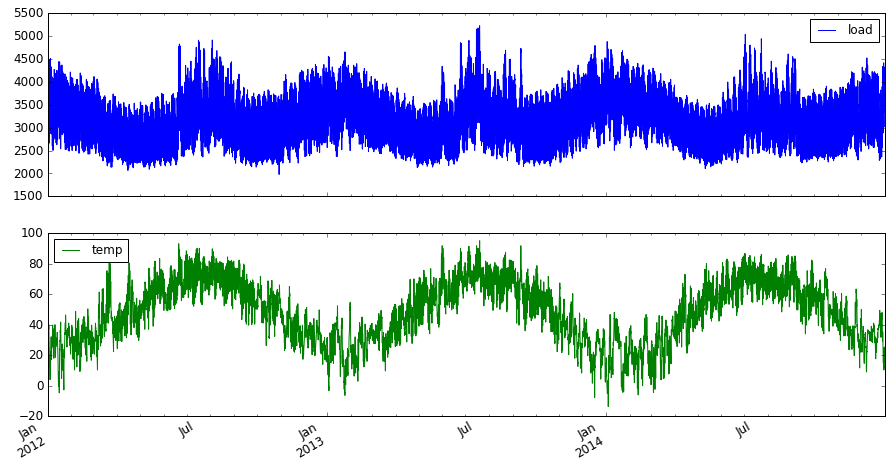

In [5]:
energy.plot(y=['load', 'temp'], subplots=True, figsize=(15, 8), fontsize=12)
plt.show()

Load and temperature in first week of July 2014

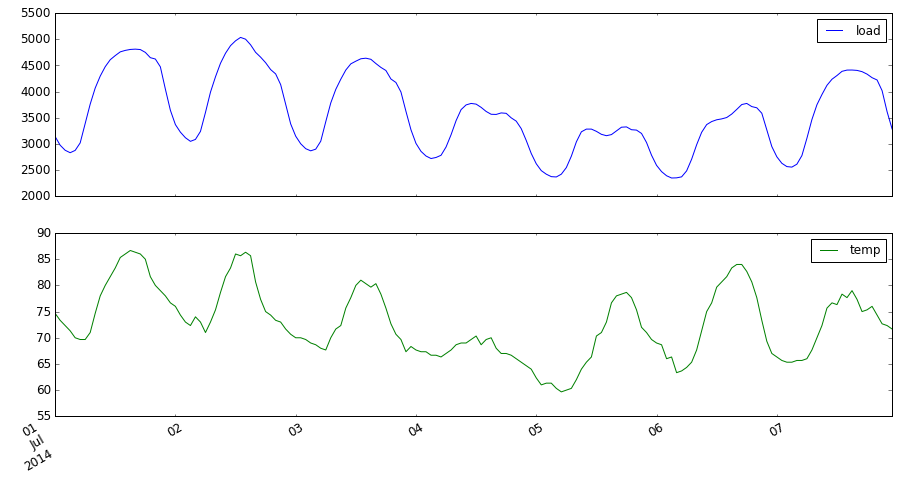

In [6]:
energy['2014-07-01':'2014-07-07'].plot(y=['load', 'temp'], subplots=True, figsize=(15, 8), fontsize=12)
plt.show()

In [7]:
T = 6
HORIZON = 1

Create training dataset with *load* and *temp* features

In [8]:
train = energy.copy()[energy.index < valid_start_dt][['load', 'temp']]

Fit a scaler for the *y* values

In [9]:
from sklearn.preprocessing import MinMaxScaler

y_scaler = MinMaxScaler()
y_scaler.fit(train[['load']])

MinMaxScaler(copy=True, feature_range=(0, 1))

Also scale the input features data (*load* and *temp* values)

In [10]:
X_scaler = MinMaxScaler()
train[['load', 'temp']] = X_scaler.fit_transform(train)

Use the TimeSeriesTensor convenience class to:
1. Shift the values of the time series to create a Pandas dataframe containing all the data for a single training example
2. Discard any samples with missing values
3. Transform this Pandas dataframe into a numpy array of shape (samples, time steps, features) for input into Keras

The class takes the following parameters:

- **dataset**: original time series
- **H**: the forecast horizon
- **tensor_structure**: a dictionary discribing the tensor structure in the form { 'tensor_name' : (range(max_backward_shift, max_forward_shift), [feature, feature, ...] ) }
- **freq**: time series frequency
- **drop_incomplete**: (Boolean) whether to drop incomplete samples

In [11]:
tensor_structure = {'X':(range(-T+1, 1), ['load', 'temp'])}
train_inputs = TimeSeriesTensor(dataset=train,
                            target='load',
                            H=HORIZON,
                            tensor_structure=tensor_structure,
                            freq='H',
                            drop_incomplete=True)

In [12]:
train_inputs.dataframe.head(10)

tensor              target    X                                               \
feature                  y load                          temp                  
time step              t+1  t-5  t-4  t-3  t-2  t-1    t  t-5  t-4  t-3  t-2   
2012-01-01 05:00:00   0.18 0.22 0.18 0.14 0.13 0.13 0.15 0.42 0.43 0.40 0.41   
2012-01-01 06:00:00   0.23 0.18 0.14 0.13 0.13 0.15 0.18 0.43 0.40 0.41 0.42   
2012-01-01 07:00:00   0.29 0.14 0.13 0.13 0.15 0.18 0.23 0.40 0.41 0.42 0.41   
2012-01-01 08:00:00   0.35 0.13 0.13 0.15 0.18 0.23 0.29 0.41 0.42 0.41 0.40   
2012-01-01 09:00:00   0.37 0.13 0.15 0.18 0.23 0.29 0.35 0.42 0.41 0.40 0.39   
2012-01-01 10:00:00   0.37 0.15 0.18 0.23 0.29 0.35 0.37 0.41 0.40 0.39 0.39   
2012-01-01 11:00:00   0.37 0.18 0.23 0.29 0.35 0.37 0.37 0.40 0.39 0.39 0.43   
2012-01-01 12:00:00   0.36 0.23 0.29 0.35 0.37 0.37 0.37 0.39 0.39 0.43 0.46   
2012-01-01 13:00:00   0.35 0.29 0.35 0.37 0.37 0.37 0.36 0.39 0.43 0.46 0.50   
2012-01-01 14:00:00   0.36 0.35 0.37 0.37 0.37 0.36 0.35 0.43 0.46 0.50 0.53   

tensor                         
feature                        
time step            t-1    t  
2012-01-01 05:00:00 0.42 0.41  
2012-01-01 06:00:00 0.41 0.40  
2012-01-01 07:00:00 0.40 0.39  
2012-01-01 08:00:00 0.39 0.39  
2012-01-01 09:00:00 0.39 0.43  
2012-01-01 10:00:00 0.43 0.46  
2012-01-01 11:00:00 0.46 0.50  
2012-01-01 12:00:00 0.50 0.53  
2012-01-01 13:00:00 0.53 0.52  
2012-01-01 14:00:00 0.52 0.54

In [13]:
train_inputs['X'].shape

(23370, 6, 2)

In [14]:
train_inputs['X'][:3]

array([[[ 0.22,  0.42],
        [ 0.18,  0.43],
        [ 0.14,  0.4 ],
        [ 0.13,  0.41],
        [ 0.13,  0.42],
        [ 0.15,  0.41]],

       [[ 0.18,  0.43],
        [ 0.14,  0.4 ],
        [ 0.13,  0.41],
        [ 0.13,  0.42],
        [ 0.15,  0.41],
        [ 0.18,  0.4 ]],

       [[ 0.14,  0.4 ],
        [ 0.13,  0.41],
        [ 0.13,  0.42],
        [ 0.15,  0.41],
        [ 0.18,  0.4 ],
        [ 0.23,  0.39]]])

In [15]:
train_inputs['target'].shape

(23370, 1)

In [16]:
train_inputs['target'][:3]

array([[ 0.18],
       [ 0.23],
       [ 0.29]])

In [17]:
look_back_dt = dt.datetime.strptime(valid_start_dt, '%Y-%m-%d %H:%M:%S') - dt.timedelta(hours=T-1)
valid = energy.copy()[(energy.index >=look_back_dt) & (energy.index < test_start_dt)][['load', 'temp']]
valid[['load', 'temp']] = X_scaler.transform(valid)
valid_inputs = TimeSeriesTensor(valid, 'load', HORIZON, tensor_structure)

## Implement the RNN

We will implement a simple RNN forecasting model with the following structure:

![One step multivariate RNN model](./images/one_step_multivariate.png "One step multivariate RNN model")

In [18]:
from keras.models import Model, Sequential
from keras.layers import GRU, Dense
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [19]:
LATENT_DIM = 5
BATCH_SIZE = 32
EPOCHS = 50

In [20]:
model = Sequential()
model.add(GRU(LATENT_DIM, input_shape=(T, 2)))
model.add(Dense(HORIZON))

In [21]:
model.compile(optimizer='RMSprop', loss='mse')

In [22]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 5)                 120       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6         
Total params: 126
Trainable params: 126
Non-trainable params: 0
_________________________________________________________________


In [23]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5)
history = model.fit(train_inputs['X'],
                    train_inputs['target'],
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(valid_inputs['X'], valid_inputs['target']),
                    callbacks=[earlystop],
                    verbose=1)

Train on 23370 samples, validate on 1463 samples
Epoch 1/50
23370/23370 [==============================] - 4s 178us/step - loss: 0.0056 - val_loss: 0.0011
Epoch 2/50
23370/23370 [==============================] - 4s 160us/step - loss: 9.3181e-04 - val_loss: 7.3534e-04
Epoch 3/50
23370/23370 [==============================] - 4s 159us/step - loss: 7.3270e-04 - val_loss: 5.6612e-04
Epoch 4/50
23370/23370 [==============================] - 4s 174us/step - loss: 6.3084e-04 - val_loss: 5.2439e-04
Epoch 5/50
23370/23370 [==============================] - 4s 152us/step - loss: 5.8032e-04 - val_loss: 5.7514e-04
Epoch 6/50
23370/23370 [==============================] - 4s 169us/step - loss: 5.5439e-04 - val_loss: 5.0937e-04
Epoch 7/50
23370/23370 [==============================] - 4s 154us/step - loss: 5.3932e-04 - val_loss: 4.6599e-04
Epoch 8/50
23370/23370 [==============================] - 4s 165us/step - loss: 5.3377e-04 - val_loss: 4.9609e-04
Epoch 9/50
23370/23370 [=======================

## Evaluate the model

In [24]:
look_back_dt = dt.datetime.strptime(test_start_dt, '%Y-%m-%d %H:%M:%S') - dt.timedelta(hours=T-1)
test = energy.copy()[test_start_dt:][['load', 'temp']]
test[['load', 'temp']] = X_scaler.transform(test)
test_inputs = TimeSeriesTensor(test, 'load', HORIZON, tensor_structure)

In [25]:
predictions = model.predict(test_inputs['X'])

In [26]:
eval_df = create_evaluation_df(predictions, test_inputs, HORIZON, y_scaler)
eval_df.head()

,timestamp,h,prediction,actual
0,2014-11-01 05:00:00,t+1,"2,719.04","2,714.00"
1,2014-11-01 06:00:00,t+1,"2,969.97","2,970.00"
2,2014-11-01 07:00:00,t+1,"3,248.43","3,189.00"
3,2014-11-01 08:00:00,t+1,"3,375.12","3,356.00"
4,2014-11-01 09:00:00,t+1,"3,518.14","3,436.00"


In [27]:
mape(eval_df['prediction'], eval_df['actual'])

0.01933742263874909

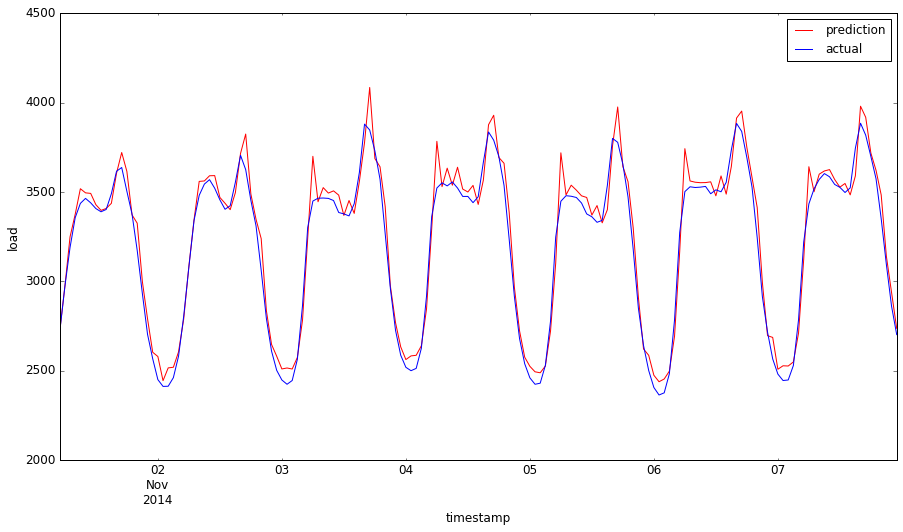

In [28]:
eval_df[eval_df.timestamp<'2014-11-08'].plot(x='timestamp', y=['prediction', 'actual'], style=['r', 'b'], figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()